# 简介:
垃圾分类器原型机, 训练数据集使用了斯坦福大学trash-net(citation见最后). 该数据集使用了2527张标记数据, 一共包含了六种不同的垃圾类型: 纸板, 玻璃，金属，纸，塑料，生活垃圾. 根据该数据集的介绍，数据集采集使用了Apple iPhone 7 Plus, Apple iPhone 5S, and Apple iPhone SE. 准确率70%. 而使用最新Fastai及Pytorch深度学习框架, 在本原型上神经网络达到了94% (注: Test set不一样)

此原型机仅做为垃圾分类器的演示版本, 实际使用时需重新采集相关图片数据. 按照垃圾分类的详细标准进行重新标注. 具体方案详见文档.

此原型机使用了ImageNet Pre-trained Resnet50 做为骨架, 输出层按照Fastai图片分类器的做法进行了重新分割设计, 最终输出结果为6.

训练分为两部. 
1. 对输出层进行训练 lr=1e-2
2. 对整体进行训练 lr = slice(2e-5,1e-2/5)

最后除了对validation set进行结果展示外, 随机拍照了一样物品进行预测.

In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd

In [2]:
path = Path('/home/jupyter/.fastai/data/trash-net/dataset-original')
path.ls()

[PosixPath('/home/jupyter/.fastai/data/trash-net/dataset-original/paper'),
 PosixPath('/home/jupyter/.fastai/data/trash-net/dataset-original/trash'),
 PosixPath('/home/jupyter/.fastai/data/trash-net/dataset-original/cardboard'),
 PosixPath('/home/jupyter/.fastai/data/trash-net/dataset-original/glass'),
 PosixPath('/home/jupyter/.fastai/data/trash-net/dataset-original/plastic'),
 PosixPath('/home/jupyter/.fastai/data/trash-net/dataset-original/metal')]

In [6]:
#数据预处理
data = (ImageList
        .from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(max_warp=0.),size=128)
        .databunch(bs=64,num_workers=8)
        .normalize(imagenet_stats)
       )

一共六种分类 纸板，玻璃，金属，纸，塑料，生活垃圾

In [4]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

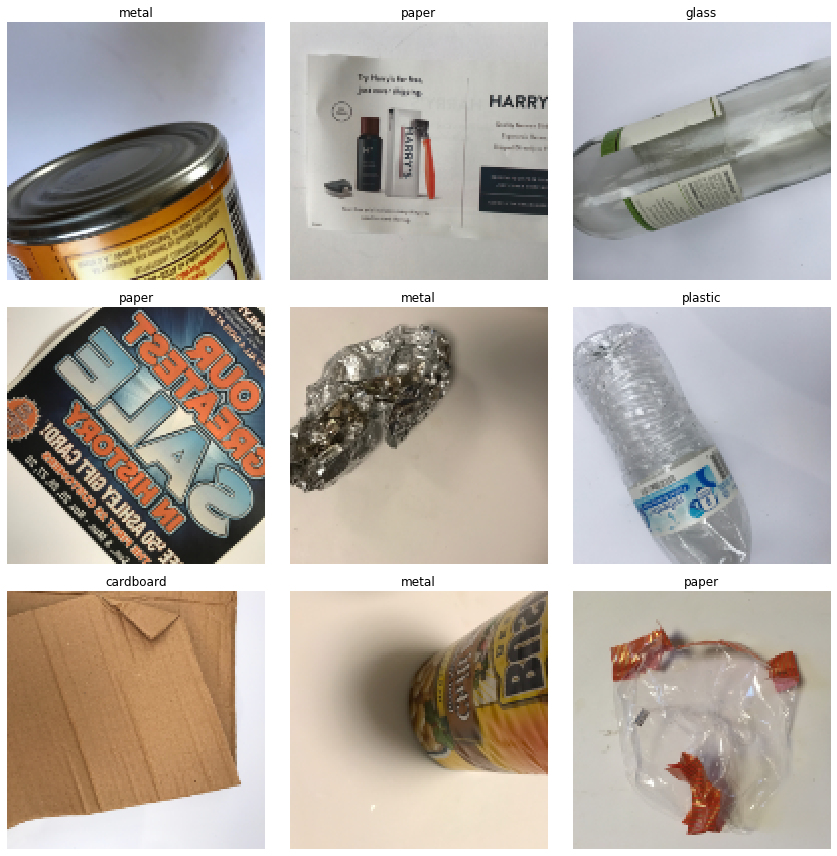

In [7]:
data.show_batch(rows=3)

# 训练

In [8]:
learn = cnn_learner(data,models.resnet50,metrics=[accuracy])

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03
Min loss divided by 10: 1.20E-02


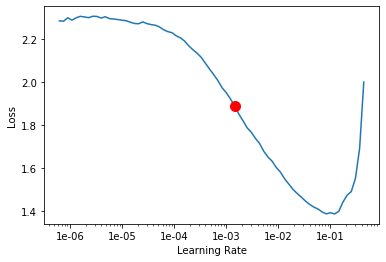

In [10]:
learn.recorder.plot(suggestion=True)

In [11]:
lr = 1e-2
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.967992,0.652839,0.805941,03:57
1,0.714521,0.574146,0.811881,03:53
2,0.542665,0.462525,0.843564,03:53
3,0.419339,0.389959,0.865347,03:53
4,0.305278,0.363153,0.879208,03:53


In [12]:
learn.save('trash-1a')

In [13]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.29E-07


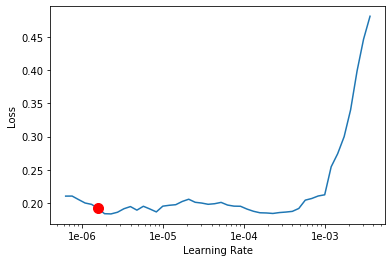

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [17]:
learn.fit_one_cycle(10,slice(2e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.195714,0.361367,0.893069,03:49
1,0.191298,0.452693,0.871287,03:48
2,0.189864,0.465075,0.887129,03:49
3,0.198653,0.402769,0.893069,03:49
4,0.161109,0.315027,0.916832,03:49
5,0.121078,0.225486,0.924752,03:50
6,0.085122,0.238616,0.926733,03:49
7,0.059228,0.257520,0.934653,03:49
8,0.042264,0.244495,0.936634,03:50
9,0.030290,0.235455,0.940594,03:49


In [18]:
learn.save('trash-2b')

# 预测
标记上方为真实值

标记下方为预测值

以图一为例子
真实值为 cardboard (纸板)
预测值为 cardboard (纸板)

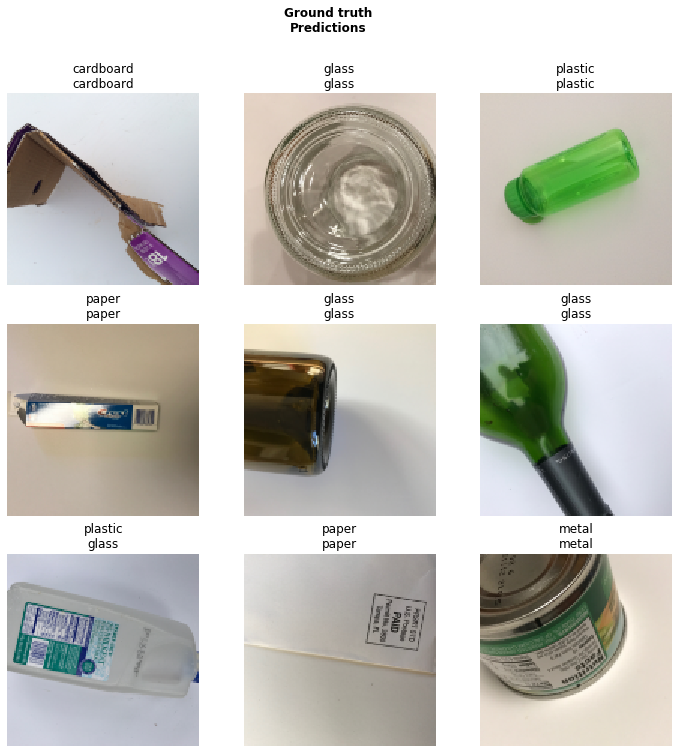

In [19]:
learn.show_results(rows=3)

上传图片
为某饼干包装外盒

期望预测结果为 纸板/纸

基于该数据库, 纸板图片大多来源纸箱, 所以期望预测应为纸 (基于训练集,大部分标注了纸的物品为 包装纸，信封等)

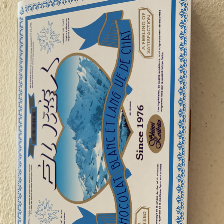

In [39]:
img_1 = open_image('/home/jupyter/dl_related/trash-classifier/paper.jpg')
img_1.resize(224)

In [23]:
learn.model.eval();

In [37]:
learn.predict(img_1)

(Category paper,
 tensor(3),
 tensor([1.9321e-03, 3.4507e-05, 8.5999e-04, 9.9556e-01, 1.2113e-04, 1.4898e-03]))

结果说明： 对单一图片预测
1. 不需要GPU，模型训练完成后仅需要CPU进行预测. 
2. 输出结果为纸, 概率为0.99556

# Citation
The dataset is used from
https://github.com/garythung/trashnet